## **Arquitectura Híbrida de Deep Learning y SVM**

En este trabajo se desarrolló un enfoque híbrido de clasificación de imágenes utilizando Deep Learning + Machine Learning clásico.

Primero, se empleó una Red Neuronal Convolucional (CNN) previamente entrenada para aprender representaciones profundas de las imágenes. En lugar de utilizar la CNN para realizar la clasificación final, se eliminó su última capa fully connected con el objetivo de convertirla en un feature extractor.

De esta manera, cada imagen fue transformada en un vector de características de alta dimensión, que encapsula patrones relevantes como texturas, bordes y estructuras visuales aprendidas durante el entrenamiento.


In [1]:
import torch
from utils import *
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\train"
test_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\test"
val_dir = r"C:\Users\Chucho\Desktop\Ciencias_de_Datos\proyectos\plant_village\data\val"

In [4]:
train_dataset = ImageFolder(root=train_dir, transform=val_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_transforms)
val_dataset = ImageFolder(root=val_dir,transform=val_transforms)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

1721
216
214


## **Cargar CNN**

In [7]:
def load_model():
    
    model = CNN()
    model.load_state_dict(torch.load("potatoes_residualCNN.pth"))
   
    return model

In [8]:
model = load_model()

In [9]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

Esta instrucción crea un nuevo modelo que utiliza únicamente las capas convolucionales del modelo original, eliminando la última capa encargada de la clasificación.

De esta manera, el modelo deja de predecir clases y pasa a funcionar como un extractor de características (feature extractor).

In [10]:
feature_extractor

Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): ResidualBlock(
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip)

## **Extractor de características**

In [11]:
def feature_extractor_vector(loader):
    
    features = []
    labels_list = []

    model.eval()
    
    with torch.no_grad():
        
        for images, labels in loader:
            
            
            output = feature_extractor(images)
            output = output.view(output.size(0), -1)  # flatten
            features.append(output.numpy())
            labels_list.append(labels.numpy())


    return features,labels_list

Esta función permite extraer automáticamente vectores de características profundas a partir de un conjunto de imágenes utilizando una red neuronal convolucional previamente entrenada, con el objetivo de emplear dichas características en modelos clásicos de Machine Learning, como SVM.

In [12]:
X_train,y_train = feature_extractor_vector(train_loader)
X_val,y_val = feature_extractor_vector(val_loader)
X_test,y_test = feature_extractor_vector(test_loader)

In [13]:
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

X_val = np.vstack(X_val)
y_val = np.hstack(y_val)

X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1721, 32)
(214, 32)
(216, 32)


## **SVM**

In [15]:
from sklearn.svm import SVC

In [16]:
svc_linear = SVC(kernel="linear",random_state = 42,probability=True)

In [17]:
svc_linear.fit(X_train,y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## **Evaluación**

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [19]:
y_pred_train = svc_linear.predict(X_train)
y_pred_val = svc_linear.predict(X_val)
y_pred_test = svc_linear.predict(X_test)

In [20]:
cm_train = confusion_matrix(y_train,y_pred_train)
cm_val = confusion_matrix(y_val,y_pred_val)
cm_test = confusion_matrix(y_test,y_pred_test)

In [21]:
def plot_confusion_matrix(cm):
  class_labels = train_dataset.class_to_idx
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_labels,
          yticklabels=class_labels)
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.title("Confusion Matrix")
  plt.show()

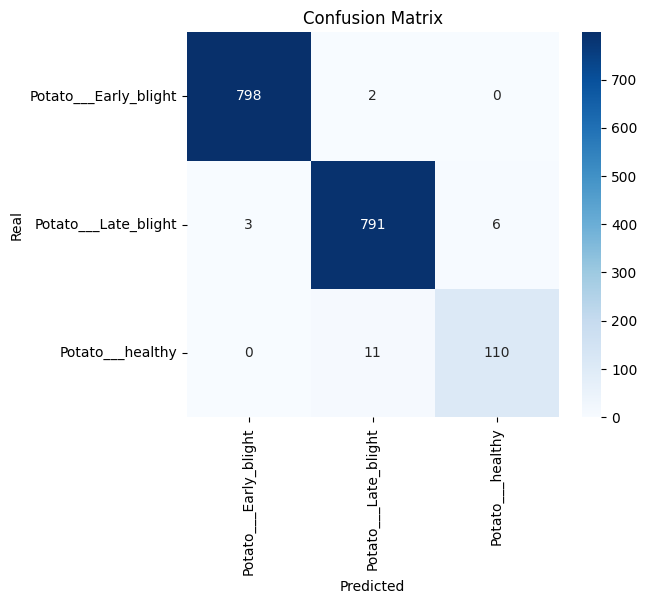

In [22]:
plot_confusion_matrix(cm_train)

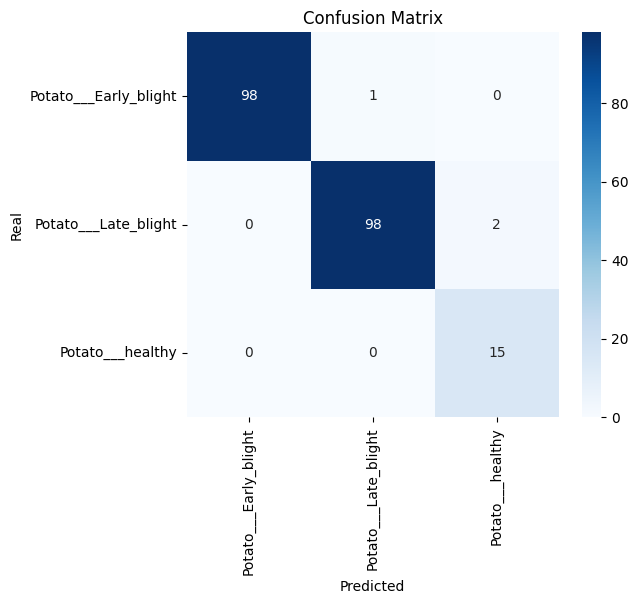

In [23]:
plot_confusion_matrix(cm_val)

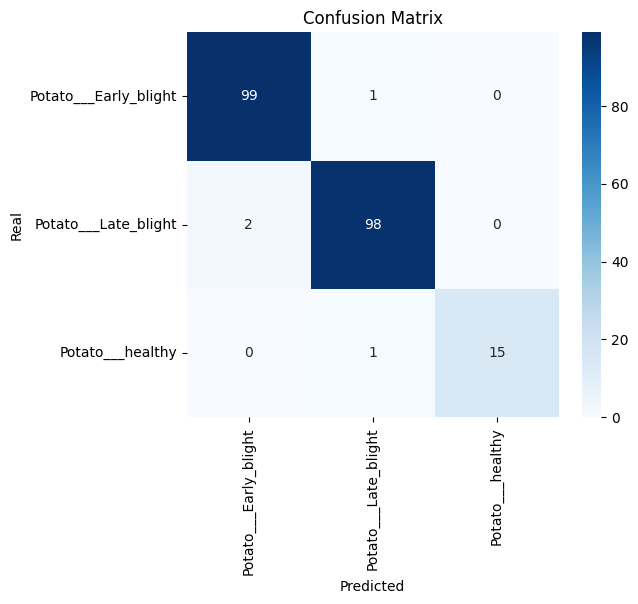

In [24]:
plot_confusion_matrix(cm_test)

In [26]:
from sklearn.metrics import classification_report,accuracy_score

In [31]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       0.98      0.99      0.99       800
           2       0.95      0.91      0.93       121

    accuracy                           0.99      1721
   macro avg       0.98      0.97      0.97      1721
weighted avg       0.99      0.99      0.99      1721



In [32]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        99
           1       0.99      0.98      0.98       100
           2       0.88      1.00      0.94        15

    accuracy                           0.99       214
   macro avg       0.96      0.99      0.97       214
weighted avg       0.99      0.99      0.99       214



In [33]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.98      0.98      0.98       100
           2       1.00      0.94      0.97        16

    accuracy                           0.98       216
   macro avg       0.99      0.97      0.98       216
weighted avg       0.98      0.98      0.98       216



In [34]:
print(f"Acc Train: {accuracy_score(y_train,y_pred_train)}")
print(f"Acc Validation: {accuracy_score(y_val,y_pred_val)}")
print(f"Acc Test: {accuracy_score(y_test,y_pred_test)}")

Acc Train: 0.9872167344567112
Acc Validation: 0.985981308411215
Acc Test: 0.9814814814814815


Los resultados muestran que el modelo híbrido CNN + SVM supera ligeramente a la CNN utilizada como clasificador directo. Esto sugiere que las características profundas extraídas por la red convolucional generan un espacio de representación altamente discriminativo, permitiendo que el SVM lineal encuentre fronteras de decisión más óptimas y generalizables. Este enfoque combina la capacidad de representación del Deep Learning con la robustez de los métodos clásicos de Machine Learning.

## **Predicciones**

In [40]:
def predict(x, feature_extractor, svc_model, transforms, device='cpu'):

    idx = {0: "Potato___Early_blight",1: "Potato___Late_blight",2: "Potato___healthy"}

    


    
    """
    Predicción usando Feature Extractor + SVM (Transfer Learning)
    
    Args:
        x: Ruta de la imagen o objeto PIL Image
        feature_extractor: Modelo CNN pre-entrenado (sin última capa FC)
        svc_model: Modelo SVM cargado con joblib
        transforms: Transformaciones de preprocesamiento
        device: 'cpu' o 'cuda'
    """
    

    
    # 1️⃣ Cargar imagen si es ruta, si no usar directamente
    if isinstance(x, str):
        img = Image.open(x).convert("RGB")
    else:
        img = x.convert("RGB") if x.mode != 'RGB' else x
    
    # 2️⃣ Aplicar transformaciones
    input_tensor = transforms(img).unsqueeze(0).to(device)
    
    # 3️⃣ Extraer características con CNN
    feature_extractor.eval()
    feature_extractor.to(device)
    
    with torch.no_grad():
        features = feature_extractor(input_tensor)
        # Flatten features: (batch, channels, h, w) -> (batch, features)
        features = features.view(features.size(0), -1)
    
    # 4️⃣ Convertir a numpy para SVM
    X_vector = features.cpu().numpy()
    
    # 5️⃣ Predicción con SVM
    pred = svc_model.predict(X_vector)[0]
    prob = svc_model.predict_proba(X_vector)[0]
    
    # 6️⃣ Preparar datos para visualización
    pred_idx = int(pred)
    pred_clase = idx[pred_idx]
    confidence = prob[pred_idx] * 100
    
    # Ordenar probabilidades de mayor a menor
    sorted_indices = np.argsort(prob)[::-1]
    sorted_probs = prob[sorted_indices]
    sorted_classes = [idx[i] for i in sorted_indices]
    
    # 7️⃣ Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    fig.patch.set_facecolor('white')
    
    # 📷 IZQUIERDA: Imagen original
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen de Entrada', fontsize=14, fontweight='bold', pad=10)
    
    # Color del recuadro según predicción
    box_color = '#4CAF50' if pred_idx == 0 else '#F44336'  # Verde Benigno, Rojo Maligno
    
    ax1.text(0.5, -0.05, f'Predicción: {pred_clase}\nConfianza: {confidence:.2f}%', 
             transform=ax1.transAxes, ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=box_color, alpha=0.9, edgecolor='black'),
             color='white')
    
    # 📊 DERECHA: Gráfico de barras de probabilidades
    colors = ['#4CAF50' if i == 0 else '#F44336' for i in sorted_indices]
    bars = ax2.barh(range(len(sorted_probs)), sorted_probs * 100, 
                    color=colors, edgecolor='black', linewidth=0.5, height=0.6)
    
    # Configurar ejes
    ax2.set_yticks(range(len(sorted_classes)))
    ax2.set_yticklabels(sorted_classes, fontsize=11, fontweight='bold')
    ax2.set_xlabel('Probabilidad (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de Probabilidades (SVM)', fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    
    # Añadir valores en las barras
    for i, (bar, prob_val) in enumerate(zip(bars, sorted_probs)):
        width = bar.get_width()
        ax2.text(width + 2, bar.get_y() + bar.get_height()/2, 
                f'{prob_val*100:.1f}%', ha='left', va='center', 
                fontsize=10, fontweight='bold')
    
    # Invertir eje Y para que la mayor probabilidad esté arriba
    ax2.invert_yaxis()
    
    # Grid horizontal
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    
    # Añadir nota técnica
    fig.text(0.5, 0.02, 'Modelo: Feature Extractor CNN + SVM | Probabilidades calibradas', 
             ha='center', fontsize=9, style='italic', color='gray')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    

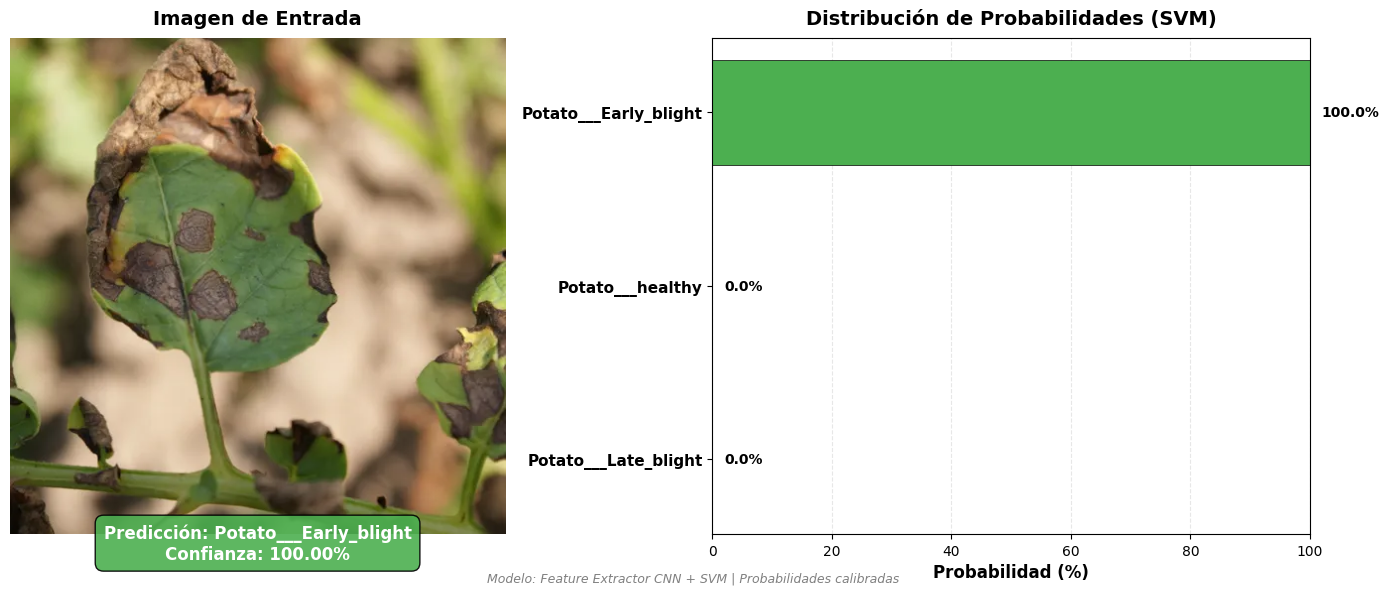

In [42]:
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2020_early_blight_potato_damage2.webp"
predict(
    x=ruta_imagen,
    feature_extractor=feature_extractor,
    svc_model = svc_linear,
    transforms=val_transforms,
    device='cpu'
)

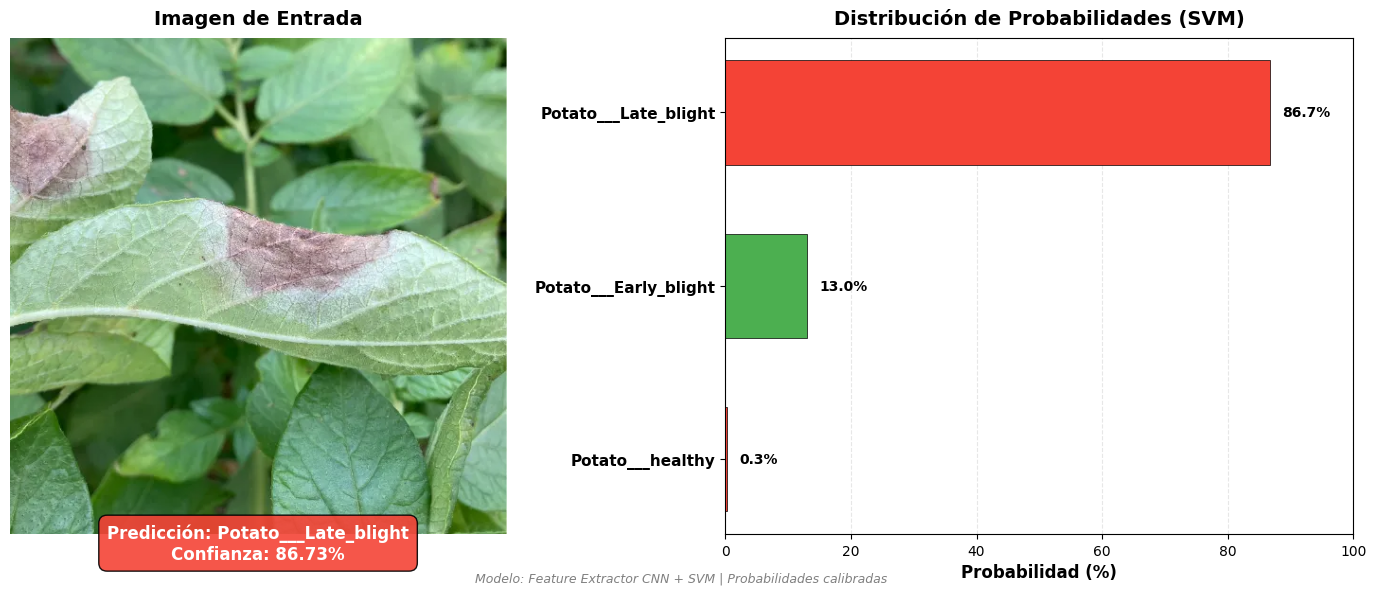

In [43]:
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2024_potato_late_blight.webp"
predict(
    x=ruta_imagen,
    feature_extractor=feature_extractor,
    svc_model = svc_linear,
    transforms=val_transforms,
    device='cpu'
)

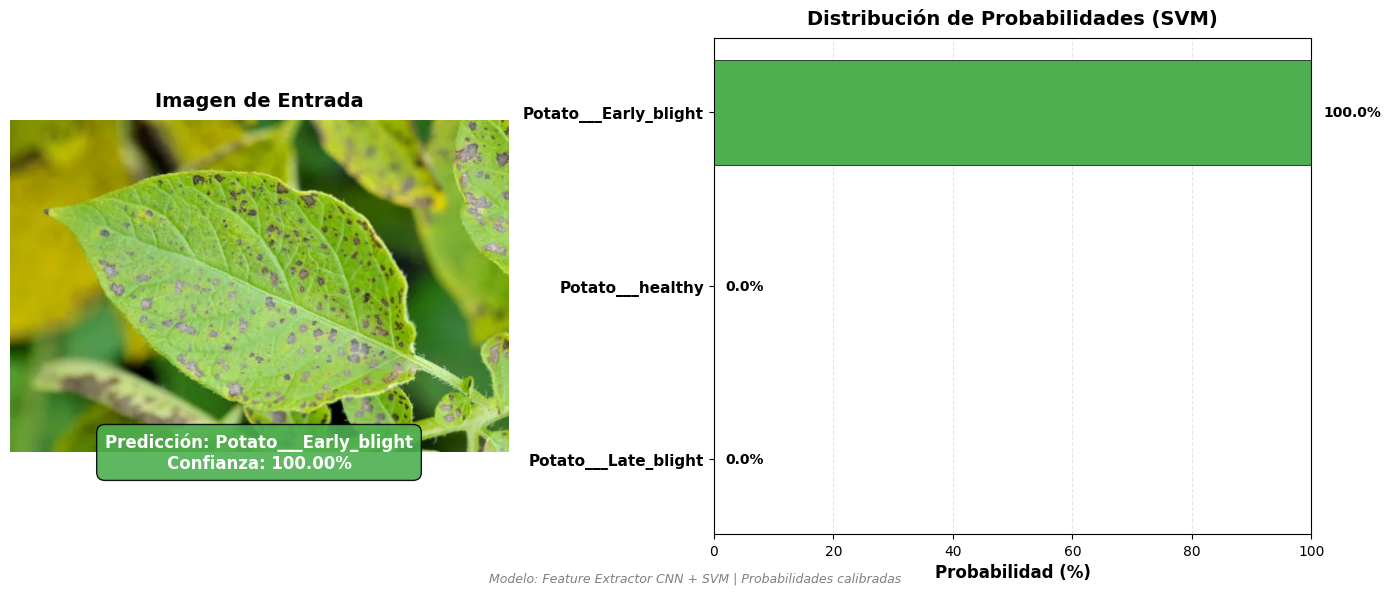

In [48]:
ruta_imagen = r"C:\Users\Chucho\Downloads\potato.webp"
predict(
    x=ruta_imagen,
    feature_extractor=feature_extractor,
    svc_model = svc_linear,
    transforms=val_transforms,
    device='cpu'
)

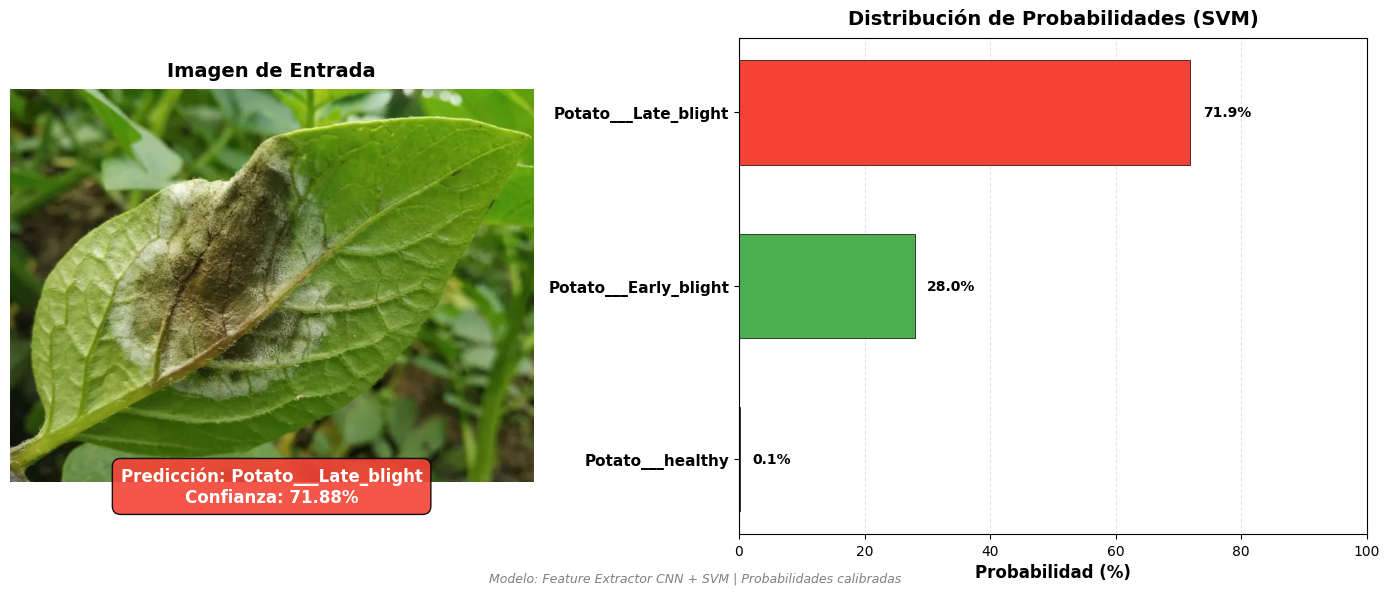

In [54]:
ruta_imagen = r"C:\Users\Chucho\Downloads\late-blight-lesion_potato-leaf-1024x769.webp"
predict(
    x=ruta_imagen,
    feature_extractor=feature_extractor,
    svc_model = svc_linear,
    transforms=val_transforms,
    device='cpu'
)

## **Guardar modelo**

In [49]:
import joblib

In [52]:
joblib.dump(svc_linear,"svc_potato.pkl")

['svc_potato.pkl']

## **Conclusión**

La CNN fue utilizada como feature extractor, permitiendo aprender representaciones profundas de las imágenes relacionadas con patrones de infección, variaciones de textura y cambios de color característicos de las enfermedades foliares. Posteriormente, dichas características fueron transformadas en vectores numéricos y empleadas como entrada para un modelo SVC lineal, encargado de realizar la clasificación final.

Este enfoque permitió aprovechar las ventajas de ambos métodos:

La capacidad del Deep Learning para extraer características complejas automáticamente.

La alta capacidad de generalización y estabilidad del SVC en espacios de características bien definidos.

Los resultados obtenidos muestran que el modelo híbrido CNN + SVC logró mejorar el desempeño de clasificación respecto al uso individual de la red convolucional, alcanzando mayores niveles de precisión y un mejor equilibrio entre clases, lo cual es especialmente relevante en problemas agrícolas donde algunas enfermedades pueden presentarse con menor frecuencia.

Además, esta estrategia reduce el riesgo de sobreajuste en datasets de tamaño moderado y permite reutilizar modelos CNN previamente entrenados sin necesidad de reentrenamiento completo, optimizando el costo computacional.

En conclusión, el uso combinado de CNN como extractor de características y SVC como clasificador constituye una alternativa eficiente y robusta para sistemas de diagnóstico automatizado de enfermedades del cultivo de papa, con potencial aplicación en herramientas de agricultura de precisión orientadas a la detección temprana y apoyo a la toma de decisiones en campo.